<a href="https://colab.research.google.com/github/tomonori-masui/time-series-forecasting/blob/main/multi_step_time_series_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-step Time Series Forecasting with ARIMA, LightGBM, and Prophet
In this notebook, we are comparing three different algorithms, namely ARIMA/SARIMA, LightGBM, and Prophet, on different types of time series datasets.

We are using the following four different time series data to compare the models:
1. Cyclic time series (Sunspots data)
2. Time Series without trend and seasonality (Nile dataset)
3. Time series with a strong trend (WPI dataset)
4. Time series with trend and seasonality (Airline dataset)

While we will try ARIMA/SARIMA and LightGBM on all the four different time series, we will model Prophet only on the Airline dataset as it is designed to work on seasonal time series.

# 0. Import Packages

In [1]:
%%capture
import os
import sys

import numpy as np
import pandas as pd
import pandas_datareader.data as web

!pip install statsmodels==0.12.2
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller

!pip install sktime==0.6.1
!pip install pmdarima==1.8.2
import lightgbm as lgb
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.compose import (TransformedTargetForecaster,
                                        make_reduction)
from sktime.forecasting.model_selection import (ExpandingWindowSplitter,
                                                ForecastingGridSearchCV)
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series

sns.set()
plt.style.use('bmh')

# 1. Cyclic Time Series (Sunspots data)

Cyclic time series have rises and falls that are not of a fixed frequency which is different from seasonal time series having a fixed and known frequency. The dataset below is yearly (1700–2008) data on sunspots from the National Geophysical Data Center.

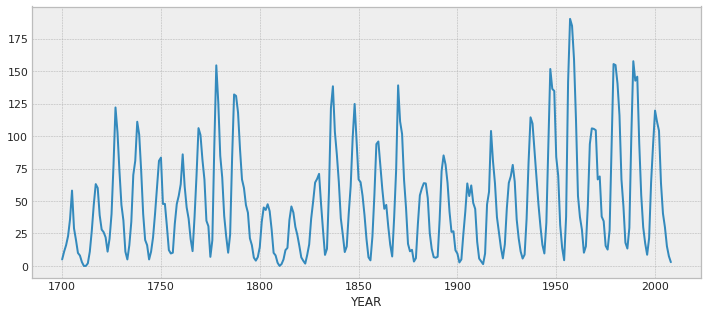

In [2]:
data = sm.datasets.sunspots.load_pandas()
ts_sun = data.data.set_index("YEAR").SUNACTIVITY

ts_sun.plot(figsize=(12, 5))
plt.show()

First, we are examining the stationarity of the time series. Stationarity means time series does not change its statistical properties over time, specifically its mean and variance. Time series with cyclic behavior is basically stationary while time series with trends or seasonalities is not stationary ([see this link for more details](https://otexts.com/fpp3/stationarity.html)). We need stationary time series to develop stable linear models, such as ARIMA.

Below we are setting up and executing a function that shows autocorrelation (ACF) and partial autocorrelation (PACF) plots along with performing Augmented Dickey–Fuller unit test.

In [3]:
import warnings
warnings.filterwarnings("ignore")

# adapted from https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python
def tsplot(y, lags=None, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
           
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

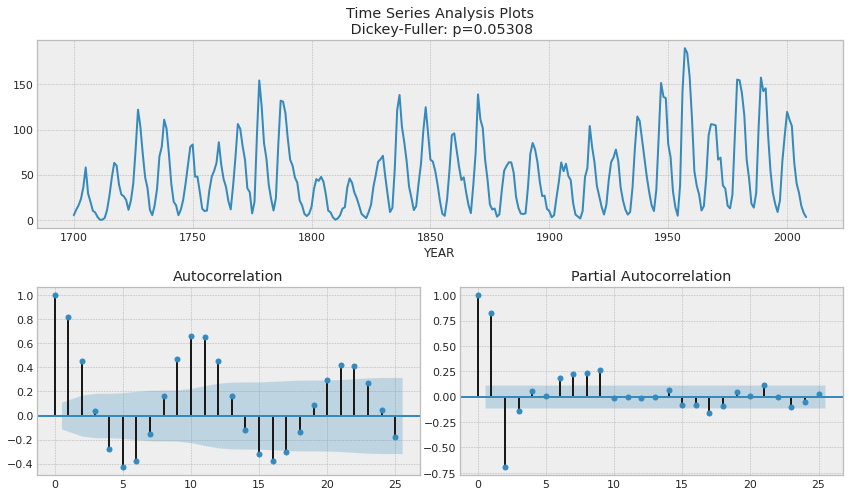

In [4]:
tsplot(ts_sun)

Autocorrelation (ACF) plot can be used to find if time series is stationarity. It also can be helpful to find the order of moving average part in ARIMA model. Partial autocorrelation (PACF) plot is useful to identify the order of autoregressive part in ARIMA model. Augmented Dickey–Fuller unit test examines if the time series is non-stationary. The null hypothesis is that the series is non-stationary, hence if the p-value is small, it implies the time series is NOT non-stationary.

In the picture above, Dickey-Fuller test p-value is not significant enough (> 5%). We are going to take the first difference to make the series more stationary.

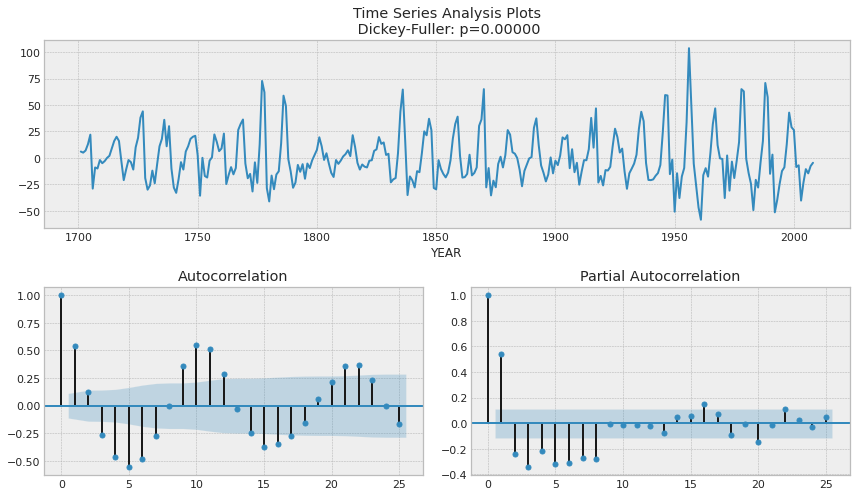

In [5]:
ts_sun_diff = (ts_sun - ts_sun.shift(1)).dropna()
tsplot(ts_sun_diff)

This time, Dickey-Fuller test p-value is significant which means the series now is more likely to be stationary.

The ACF plot shows a sinusoidal pattern and there are significant values up until lag 8 in the PACF plot. This implies ARIMA(8,1,0) model (We took the first difference, hence d=1). You can see the general rules to determine the orders on ARIMA parameters from ACF/PACF plots [in this link](https://otexts.com/fpp3/non-seasonal-arima.html#acf-and-pacf-plots)

In the next step, we are going to use `AutoARIMA` in `sktime` package which automatically optimizes the orders of ARIMA parameters. Given that, the plot analysis above to find the right orders on ARIMA parameters looks unnecessary, but it still helps us to determine the search range of the parameter orders and also enables us to verify the outcome of `AutoARIMA`.

Before modeling, we are splitting the data into a training set and a test set. The first 80% of the series is going to be the training set and the rest 20% is going to be the test set.

In [6]:
test_len = int(len(ts_sun) * 0.2)
sun_train, sun_test = ts_sun.iloc[:-test_len], ts_sun.iloc[-test_len:]

## 1.1 ARIMA on Sunspots dataset

ARIMA is one of the most popular time series forecasting models which uses both past values of the series (autoregression) and past forecasting errors (moving average) in a regression-like model. The model has three different parameters p, d, and q. p is the order of the autoregressive part, d is the degree of first difference involved, and q is the order of the moving average part. We need to find the right values on these parameters to get the most suitable model on our time series. We are using [sktime's AutoARIMA](https://www.sktime.org/en/latest/api_reference/modules/auto_generated/sktime.forecasting.arima.AutoARIMA.html) here which is a wrapper of [pmdarima](http://alkaline-ml.com/pmdarima/) and can find ARIMA parameters (p, d, q) automatically. pmdarima is a Python project which replicates [R's auto.arima](https://www.rdocumentation.org/packages/forecast/versions/8.15/topics/auto.arima) functionarity. You can see how auto.arima automatically tunes the parameters in [this link](https://otexts.com/fpp2/arima-r.html). As the analysis above suggests ARIMA(8,1,0) model, we set start_p and max_p with 8 and 9 respectively.

In [7]:
forecaster = AutoARIMA(start_p=8, max_p=9, suppress_warnings=True)
sun_train.index = sun_train.index.astype(int)
forecaster.fit(sun_train)
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  248
Model:               SARIMAX(8, 0, 1)   Log Likelihood               -1005.432
Date:                Mon, 05 Jul 2021   AIC                           2032.863
Time:                        23:11:20   BIC                           2071.511
Sample:                             0   HQIC                          2048.421
                                - 248                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.3716      2.482      1.358      0.174      -1.493       8.236
ar.L1          1.6994      0.217      7.836      0.000       1.274       2.124
ar.L2         -1.0801      0.292     -3.695      0.000      -1.653      -0.507
ar.L3          0.1148      0.168      0.682      0.495      -0.215       0.445
ar.L4          0.2228      0.168      1.329      0.184      -0.106       0.552
ar.L5         -0.2164      0.176     -1.233      0.218      -0.560       0.128
ar.L6          0.1115      0.160      0.696      0.487      -0.203       0.426
ar.L7         -0.0785      0.159     -0.493      0.622      -0.391       0.234
ar.L8          0.1515      0.109      1.393      0.164      -0.062       0.365
ma.L1         -0.4613      0.216     -2.139      0.032      -0.884      -0.039
sigma2       191.6654     14.255     13.445      0.000     163.726     219.605
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                43.16
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                             0.62
Prob(H) (two-sided):                  0.61   Kurtosis:                         4.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

It turned out AutoARIMA picked slightly different parameters from our beforehand expectation.

Next, we are setting up a function below which plots the model forecast along with evaluating the model performance. We are using [mean absolute error (MAE)](https://en.wikipedia.org/wiki/Mean_absolute_error) and [mean absolute percentage error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error) for the performance metrics.

MAE averages absolute prediction error over the prediction period:

$MAE = \frac{\sum\limits_{t=1}^{n} |y_t - \hat{y}_t|}{n}$ 

$t$ is time, $y_t$ is actual $y$ value at $t$, $\hat{y}_t$ is predicted value, and $n$ is forecasting horizon. 

MAPE is a scaled metric which is dividing absolute error by the actual $y$:

$MAPE = \frac{100}{n}\sum\limits_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{y_i}$ 


In [8]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error


def plot_forecast(series_train, series_test, forecast, forecast_int=None):

    mae = mean_absolute_error(series_test, forecast)
    mape = mean_absolute_percentage_error(series_test, forecast)

    plt.figure(figsize=(12, 6))
    plt.title(f"MAE: {mae:.2f}, MAPE: {mape:.3f}", size=18)
    series_train.plot(label="train", color="b")
    series_test.plot(label="test", color="g")
    forecast.index = series_test.index
    forecast.plot(label="forecast", color="r")
    if forecast_int is not None:
        plt.fill_between(
            series_test.index,
            forecast_int["lower"],
            forecast_int["upper"],
            alpha=0.2,
            color="dimgray",
        )
    plt.legend(prop={"size": 16})
    plt.show()

    return mae, mape

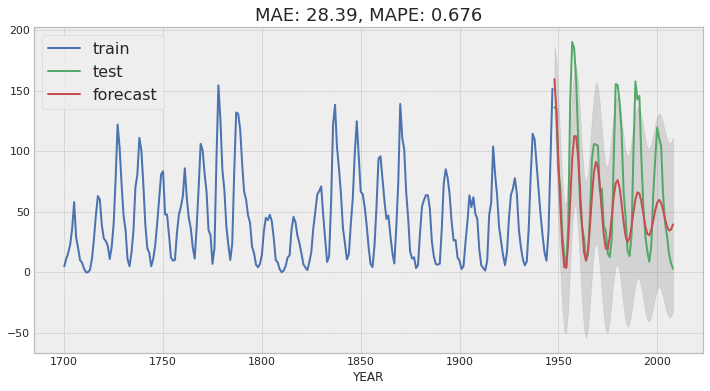

In [9]:
fh = np.arange(test_len) + 1
forecast, forecast_int = forecaster.predict(fh=fh, return_pred_int=True, alpha=0.05)
sun_arima_mae, sun_arima_mape = plot_forecast(
    sun_train, sun_test, forecast, forecast_int
)

## 1.2 LightGBM on Sunspots dataset
To make a forecast with LightGBM, we need to transform time series data into tabular format first where features are created with lagged values of the time series itself (i.e. 𝑦𝑡−1, 𝑦𝑡−2, 𝑦𝑡−3, …). As the model can only predict a one-step forecast, the predicted value is used for the feature in the next step when we create multi-step forecasting, which is called recursive approach for multi-step forecasting (you can find different approaches for multi-step forecasting [in this paper](https://www.researchgate.net/publication/236941795_Machine_Learning_Strategies_for_Time_Series_Forecasting)). [sktime](https://github.com/alan-turing-institute/sktime) package provides us these functionalities with a convenient API. In the `create_forecaster` function below, `make_reduction` wraps `LGBMRegressor` and converts input time series into the tabular format when we fit the forecaster.

We are also using `ForecastingGridSearchCV` to find the best window_length of the lagged features.

best params: {'window_length': 20}


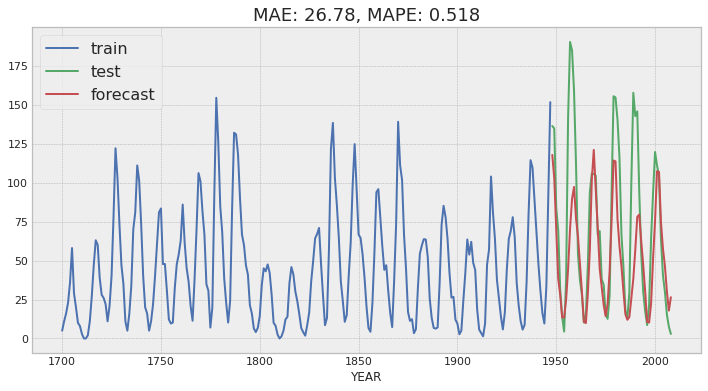

In [10]:
def create_forecaster():

    # creating forecaster with LightGBM
    regressor = lgb.LGBMRegressor()
    forecaster = make_reduction(regressor, window_length=5, strategy="recursive")

    return forecaster


def grid_serch_forecaster(train, test, forecaster, param_grid):

    # Grid search on window_length
    cv = ExpandingWindowSplitter(initial_window=int(len(train) * 0.7))
    gscv = ForecastingGridSearchCV(
        forecaster, strategy="refit", cv=cv, param_grid=param_grid
    )
    gscv.fit(train)
    print(f"best params: {gscv.best_params_}")

    # forecasting
    fh = np.arange(len(test)) + 1
    y_pred = gscv.predict(fh=fh)
    mae, mape = plot_forecast(train, test, y_pred)

    return mae, mape


param_grid = {
    "window_length": [5, 10, 15, 20, 25, 30] # parameter set to be grid searched
}
forecaster = create_forecaster()
sun_lgb_mae, sun_lgb_mape = grid_serch_forecaster(
    sun_train, sun_test, forecaster, param_grid
)

The table below summarizes the outcome of the two different models. For this time series data, LightGBM performs better than ARIMA.

In [11]:
pd.options.display.float_format = "{:.3f}".format
pd.DataFrame(
    {"MAE": [sun_arima_mae, sun_lgb_mae], "MAPE": [sun_arima_mape, sun_lgb_mape]},
    index=["ARIMA", "LightGBM"],
)

,MAE,MAPE
ARIMA,28.387,0.676
LightGBM,26.776,0.518


# 2. Time Series without trend and seasonality (Nile Dataset)
Nile dataset contains measurements on the annual flow of the Nile as measured at Ashwan for 100 years from 1871–1970. The time series does not have any seasonality nor obvious trend.

In [12]:
ts_nl = sm.datasets.get_rdataset("Nile").data
ts_nl = ts_nl.set_index('time').value

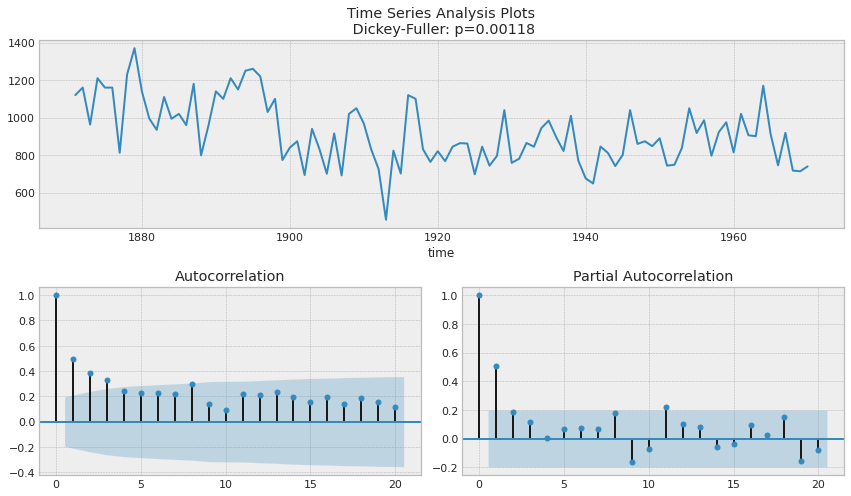

In [13]:
tsplot(ts_nl)

While Dickey-Fuller test implies it's stationary, there is some autocorrelation as can be seen in ACF plot. We are trying to see how its first difference looks like.

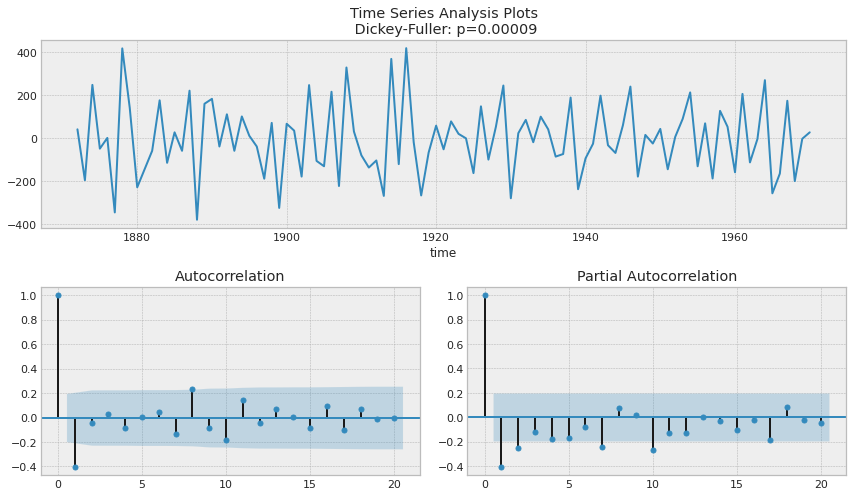

In [14]:
ts_nl_diff = (ts_nl - ts_nl.shift(1)).dropna()
tsplot(ts_nl_diff)

This looks more stationary than the original as the ACF plot shows an immediate drop and also Dicky-Fuller test shows a more significant p-value. From this analysis, we would expect ARIMA with (1, 1, 0), (0, 1, 1), or any combination values on p and q with d = 1 since ACF and PACF shows significant values at lag 1. Let's see what parameter values AutoARIMA picks.

## 2.1 ARIMA on Nile dataset

In [15]:
test_len = int(len(ts_nl) * 0.3)
nl_train, nl_test = ts_nl.iloc[:-test_len], ts_nl.iloc[-test_len:]

In [16]:
forecaster = AutoARIMA(suppress_warnings=True)
forecaster.fit(nl_train)
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   70
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -444.051
Date:                Mon, 05 Jul 2021   AIC                            894.102
Time:                        23:11:40   BIC                            900.805
Sample:                             0   HQIC                           896.761
                                 - 70                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2579      0.156      1.654      0.098      -0.048       0.564
ma.L1         -0.8627      0.072    -11.978      0.000      -1.004      -0.722
sigma2      2.247e+04   3960.472      5.675      0.000    1.47e+04    3.02e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 0.41
Prob(Q):                              0.72   Prob(JB):                         0.82
Heteroskedasticity (H):               0.48   Skew:                            -0.15
Prob(H) (two-sided):                  0.08   Kurtosis:                         2.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The model picked d = 1 as expected and has 1 on both p and q. Then, we are creating a forecast with its evaluation.

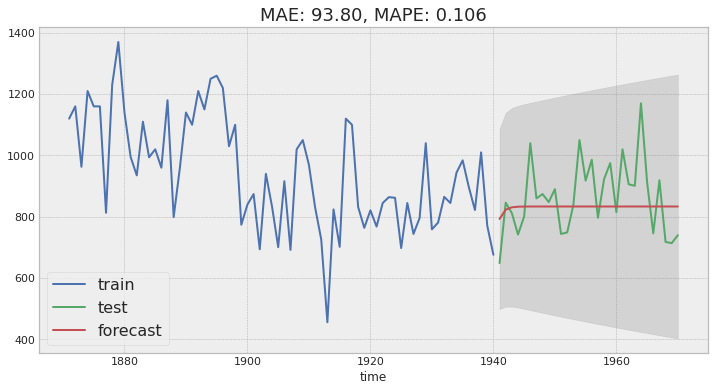

In [17]:
fh = np.arange(test_len) + 1
forecast, forecast_int = forecaster.predict(fh=fh, return_pred_int=True, alpha=0.05)
nl_arima_mae, nl_arima_mape = plot_forecast(nl_train, nl_test, forecast, forecast_int)

As there are no clear patterns in the time series, the model predicts almost constant value over time.

## 2.2 LightGBM on Nile dataset

We are using the same functions as the previous data to develop LightGBM.

best params: {'window_length': 30}


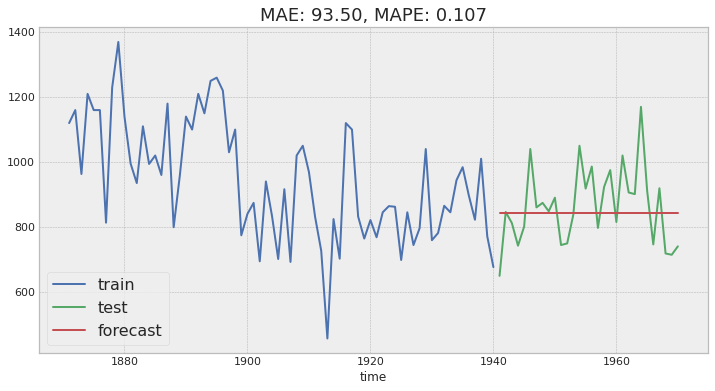

In [18]:
param_grid = {"window_length": [5, 10, 15, 20, 25, 30]}
forecaster = create_forecaster()
nl_lgb_mae, nl_lgb_mape = grid_serch_forecaster(
    nl_train, nl_test, forecaster, param_grid
)

It turned out LightGBM creates a similar forecast as ARIMA. The summary table below shows there is not much difference between the two models.

In [19]:
pd.DataFrame(
    {"MAE": [nl_arima_mae, nl_lgb_mae], "MAPE": [nl_arima_mape, nl_lgb_mape]},
    index=["ARIMA", "LightGBM"],
)

,MAE,MAPE
ARIMA,93.805,0.106
LightGBM,93.497,0.107


# 3. Time series with a strong trend (WPI dataset)
U.S. Wholesale Price Index (WPI) from 1960 to 1990 has a strong trend as can be seen below.

In [20]:
import requests
from io import BytesIO

wpi1 = requests.get("https://www.stata-press.com/data/r12/wpi1.dta").content
data = pd.read_stata(BytesIO(wpi1))
ts_wpi = data.set_index("t").wpi

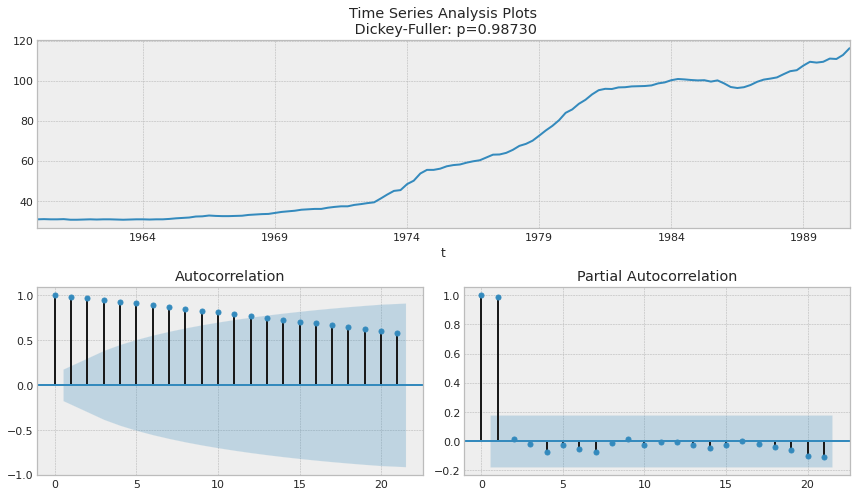

In [21]:
tsplot(ts_wpi)

We are taking the first difference to make it stationary.

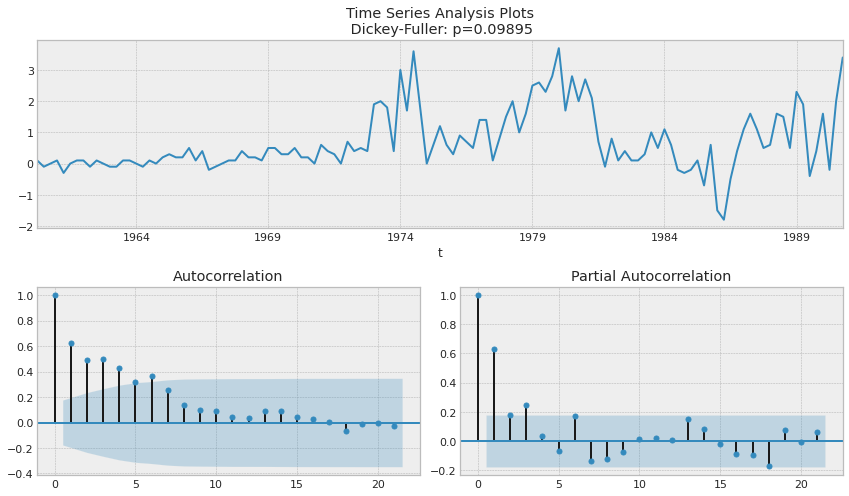

In [22]:
ts_wpi_diff = (ts_wpi - ts_wpi.shift(1)).dropna()
tsplot(ts_wpi_diff)

It still looks non-stationary as the ACF drops slowly over time and Dicky-Fuller also does not show a significant p-value. Hence, we are taking one more difference.

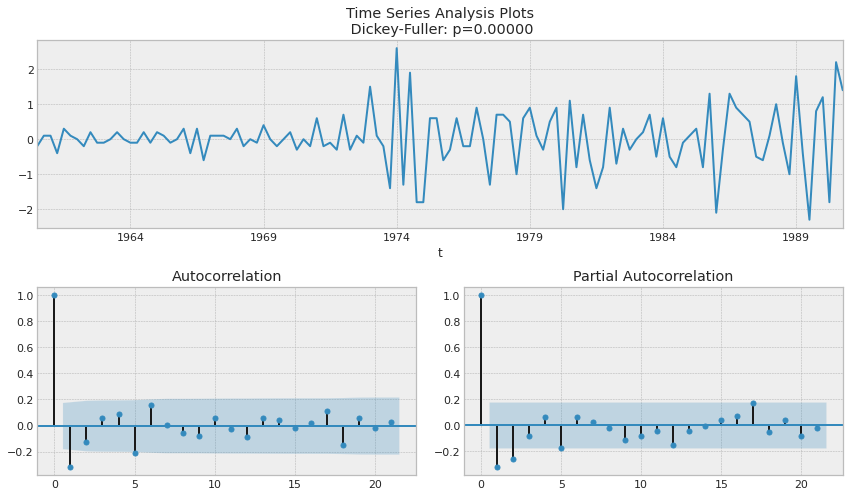

In [23]:
ts_wpi_2diff = (ts_wpi_diff - ts_wpi_diff.shift(1)).dropna()
tsplot(ts_wpi_2diff)

Now, it looks stationary with the Dicky-Fuller's significant value and the ACF plot showing the rapid drop. From this analysis, we would expect d = 2 as it required second difference to make it stationary. As the ACF has a significant value at lag 1 and the PACF has the ones untile lag 2, we can expect q = 1 or p = 2.

## 3.1 ARIMA on WPI dataset

We are splitting the time series into training and test set, then train ARIMA model on it.

In [24]:
ts_wpi.index = ts_wpi.index.to_period("Q")
test_len = int(len(ts_wpi) * 0.25)
wpi_train, wpi_test = ts_wpi.iloc[:-test_len], ts_wpi.iloc[-test_len:]

In [25]:
forecaster = AutoARIMA(suppress_warnings=True)
forecaster.fit(wpi_train)
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   93
Model:               SARIMAX(0, 2, 1)   Log Likelihood                 -87.054
Date:                Mon, 05 Jul 2021   AIC                            178.108
Time:                        23:11:48   BIC                            183.130
Sample:                             0   HQIC                           180.134
                                 - 93                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4906      0.074     -6.674      0.000      -0.635      -0.347
sigma2         0.3955      0.038     10.490      0.000       0.322       0.469
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                32.14
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):              17.65   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

As confirmed in the previous analysis, the model has a second degree of differences. Next, we are creating a forecast along with its evaluation.

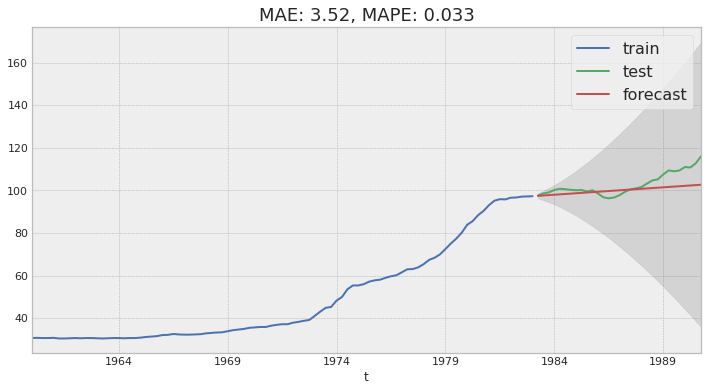

In [26]:
fh = np.arange(test_len) + 1
forecast, forecast_int = forecaster.predict(fh=fh, return_pred_int=True, alpha=0.05)
wpi_arima_mae, wpi_arima_mape = plot_forecast(
    wpi_train, wpi_test, forecast, forecast_int
)

## 3.2 LightGBM on WPI dataset

We are modeling LightGBM in the same way as before to see how it works on this time series.

best params: {'window_length': 25}


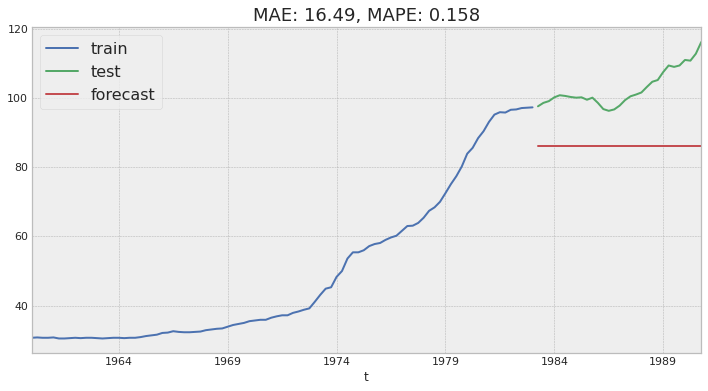

In [27]:
param_grid = {"window_length": [5, 10, 15, 20, 25, 30]}
forecaster = create_forecaster()
wpi_lgb_mae, wpi_lgb_mape = grid_serch_forecaster(
    wpi_train, wpi_test, forecaster, param_grid
)

LightGBM is clearly not working well. As the regression tree algorithm cannot predict values beyond what it has seen in training data, it suffers if there is a strong trend on time series. In this case, we need to detrend the time series before modeling. `sktime` offers a convenient tool `Detrender` and `PolynomialTrendForecasterto` detrend the input series which can be included in the training module.

Before including it in the training module, we are demonstrating `PolynomialTrendForecaster` below to see how it works.

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f38f9dc5550>)

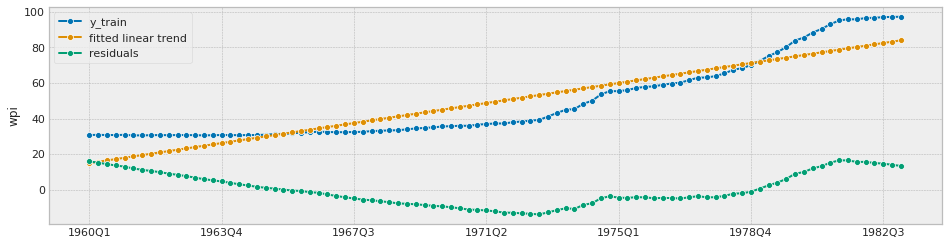

In [28]:
# linear detrending
forecaster = PolynomialTrendForecaster(degree=1)
transformer = Detrender(forecaster=forecaster)
yt = transformer.fit_transform(wpi_train)

forecaster = PolynomialTrendForecaster(degree=1)
fh_ins = -np.arange(len(wpi_train))  # in-sample forecasting horizon
y_pred = forecaster.fit(wpi_train).predict(fh=fh_ins)

plot_series(
    wpi_train, y_pred, yt, labels=["y_train", "fitted linear trend", "residuals"]
)

You can see the trend forecaster captures the trend in the time series in the picture above.

Next, we are creating a forecaster using `TransformedTargetForecaster` which includes both `Detrender` wrapping `PolynomialTrendForecasterand` and `LGBMRegressor` wrapped in `make_reduction` function, then train it with grid search on `window_length`.

best params: {'forecast__window_length': 25}


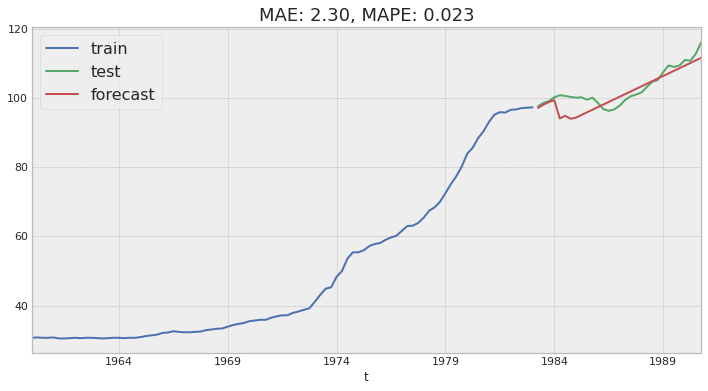

In [29]:
def create_forecaster_w_detrender(degree=1):

    # creating forecaster with LightGBM
    regressor = lgb.LGBMRegressor()
    forecaster = TransformedTargetForecaster(
        [
            ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=degree))),
            (
                "forecast",
                make_reduction(regressor, window_length=5, strategy="recursive"),
            ),
        ]
    )

    return forecaster


param_grid = {"forecast__window_length": [5, 10, 15, 20, 25, 30]}
forecaster = create_forecaster_w_detrender(degree=1)
wpi_lgb_mae, wpi_lgb_mape = grid_serch_forecaster(
    wpi_train, wpi_test, forecaster, param_grid
)

This time LightGBM is forecasting the value beyond the training target range with the help of the detrender.

The table below summarizes the performance of the two different models on the WPI data. LightGBM again performs better than ARIMA.

In [30]:
pd.options.display.float_format = "{:.3f}".format
pd.DataFrame(
    {"MAE": [wpi_arima_mae, wpi_lgb_mae], "MAPE": [wpi_arima_mape, wpi_lgb_mape]},
    index=["ARIMA", "LightGBM"],
)

,MAE,MAPE
ARIMA,3.520,0.033
LightGBM,2.304,0.023


# 4. Time series with trend and seasonality (Airline dataset)
The Box-Jenkins airline dataset consists of the number of monthly totals of international airline passengers (thousand units) from 1949–1960. This data has both trend and seasonality as can be seen below.

In [31]:
from sktime.datasets import load_airline
ts_al = load_airline()

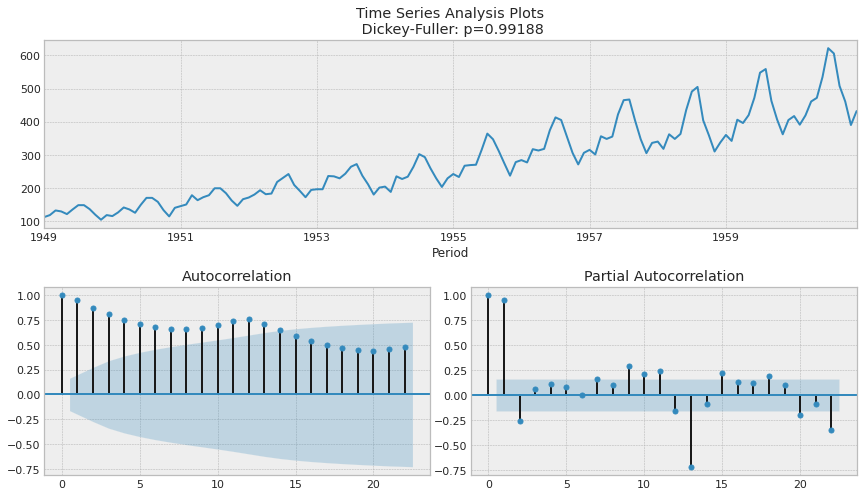

In [32]:
tsplot(ts_al)

First, we are taking a seasonal difference (lag 12) to make it stationary.

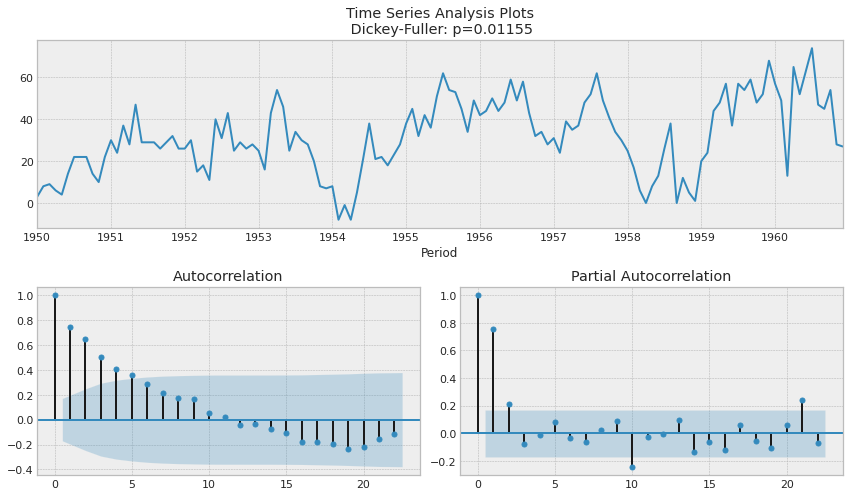

In [33]:
ts_al_diff = (ts_al - ts_al.shift(12)).dropna()
tsplot(ts_al_diff)

It still looks not stationary with ACF dropping slowly, so we are taking an additional first difference on it.

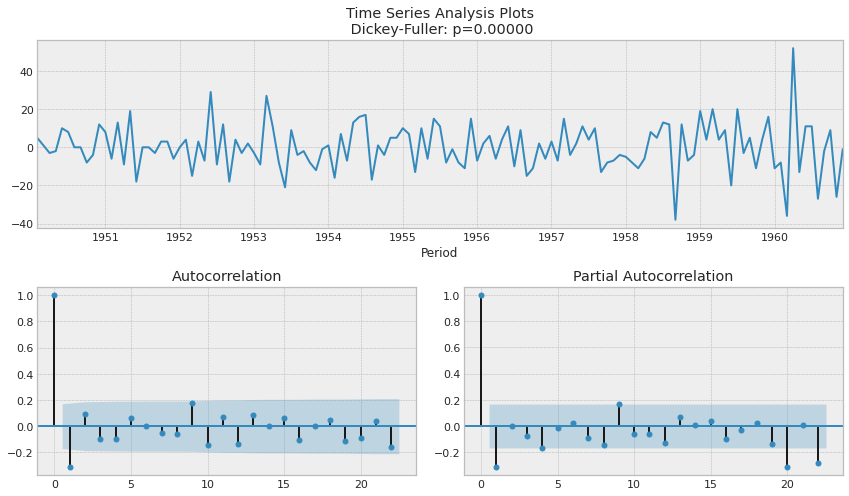

In [34]:
ts_al_2diff = (ts_al_diff - ts_al_diff.shift(1)).dropna()
tsplot(ts_al_2diff)

Now, it looks stationary as Dickey-Fuller's p-value is significant and the ACF plot shows a quick drop over time. The outcome of this analysis implies SARIMA with d = 1 and D (order of seasonal difference) = 1.p or q can be 1 as ACF and PACF plots show significant value at lag 1.

## 4.1 SARIMA on Airline dataset

Next, we split the data into training and test set and then develop SARIMA (Seasonal ARIMA) model on them. SARIMA model has additional seasonal parameters (P, D, Q) over ARIMA. P, D, and Q represent order of seasonal autocorrelation, degree of seasonal difference, and order of seasonal moving average respectively. To model SARIMA, we need to specify sp parameter (seasonal period. In this case it is 12) on AutoARIMA.

In [35]:
test_len = int(len(ts_al) * 0.3)
al_train, al_test = ts_al.iloc[:-test_len], ts_al.iloc[-test_len:]

In [36]:
forecaster = AutoARIMA(sp=12, suppress_warnings=True)
forecaster.fit(al_train)
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  101
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -322.277
Date:                            Mon, 05 Jul 2021   AIC                            650.553
Time:                                    23:12:15   BIC                            657.985
Sample:                                         0   HQIC                           653.548
                                            - 101                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2445      0.096     -2.551      0.011      -0.432      -0.057
ar.S.L12      -0.2124      0.086     -2.456      0.014      -0.382      -0.043
sigma2        88.1997     13.733      6.422      0.000      61.284     115.116
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.40
Prob(Q):                              0.96   Prob(JB):                         0.30
Heteroskedasticity (H):               1.30   Skew:                             0.40
Prob(H) (two-sided):                  0.48   Kurtosis:                         2.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

As expected, the created model has d = 1 and D = 1. Next, we create a forecast with its evaluation.

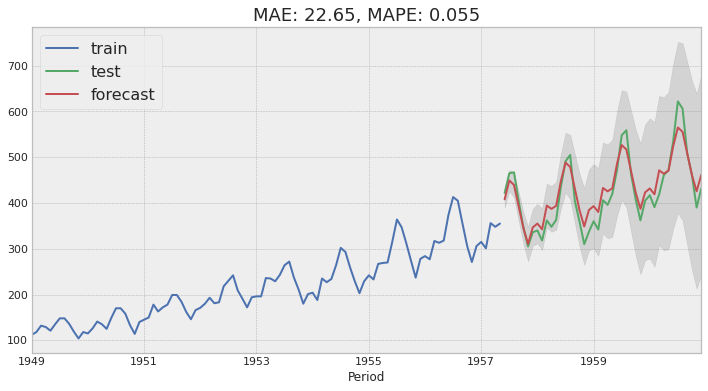

In [37]:
fh = np.arange(test_len) + 1
forecast, forecast_int = forecaster.predict(fh=fh, return_pred_int=True, alpha=0.05)
al_arima_mae, al_arima_mape = plot_forecast(al_train, al_test, forecast, forecast_int)

## 4.2 LightGBM on Airline dataset

As the time series has seasonality, we are adding `Deseasonalizer` in our LightGBM forecaster module. As the seasonality effect varies across years, we are setting `"multiplicative"` on `Deseasonalizer` module.

In [38]:
def create_forecaster_w_desesonalizer(sp=12, degree=1):

    # creating forecaster with LightGBM
    regressor = lgb.LGBMRegressor()
    forecaster = TransformedTargetForecaster(
        [
            ("deseasonalize", Deseasonalizer(model="multiplicative", sp=sp)),
            ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=degree))),
            (
                "forecast",
                make_reduction(regressor, window_length=12, strategy="recursive"),
            ),
        ]
    )

    return forecaster

best params: {'forecast__window_length': 12}


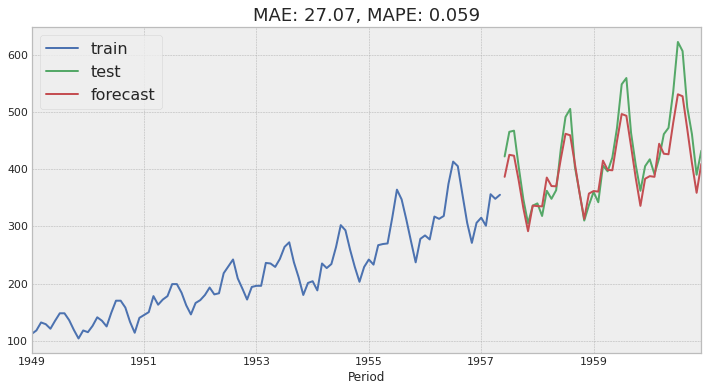

In [39]:
forecaster = create_forecaster_w_desesonalizer()
param_grid = {"forecast__window_length": [6, 12, 18, 24, 30, 36]}

al_lgb_mae, al_lgb_mape = grid_serch_forecaster(
    al_train, al_test, forecaster, param_grid
)

## 4.3 Prophet
[Prophet](https://facebook.github.io/prophet/) is a time series forecasting model developed by Facebook in 2017 which can effectively deal with multiple seasonalities (yearly, weekly, and daily). It also has capabilities incorporating the effects of holidays and implementing custom trend changes in the time series. As our time series do not require all of those functionalities, we are just using Prophet only with yearly seasonality turned on.

In [40]:
al_train_pp = al_train.to_timestamp(freq="M").reset_index()
# Prophet requires specific column names: ds and y
al_train_pp.columns = ["ds", "y"]

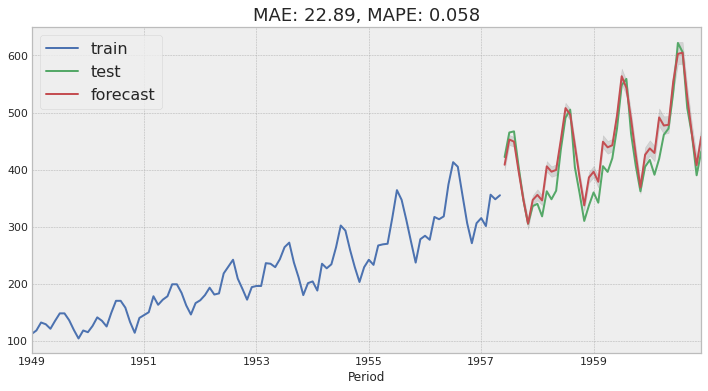

In [41]:
# turning on only yearly seasonality as this is monthly data.
# As the seasonality effects varies across years, we need multiplicative seasonality mode
m = Prophet(
    seasonality_mode="multiplicative",
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
)
m.fit(al_train_pp)

future = m.make_future_dataframe(periods=test_len, freq="M")
forecast = m.predict(future)
forecast = forecast.iloc[-test_len:]
forecast.rename(columns={"yhat_lower": "lower", "yhat_upper": "upper"}, inplace=True)
al_pph_mae, al_pph_mape = plot_forecast(
    al_train, al_test, forecast["yhat"], forecast[["lower", "upper"]]
)

The table below compares the performance metrics with the three different models on the Airline dataset. While there is not much performance difference between those three models, ARIMA performed slightly better than others.

In [42]:
pd.options.display.float_format = "{:.3f}".format
pd.DataFrame(
    {
        "MAE": [al_arima_mae, al_pph_mae, al_lgb_mae],
        "MAPE": [al_arima_mape, al_pph_mape, al_lgb_mape],
    },
    index=["ARIMA", "Prophet", "LightGBM"],
)

,MAE,MAPE
ARIMA,22.653,0.055
Prophet,22.885,0.058
LightGBM,27.067,0.059


# Conclusion

In this blog post, we compared the three different model algorithms on the different types of time series. LightGBM showed comparable or better performance than ARIMA except for the time series with seasonality (Airline).

||ARIMA/SARIMA|LightGBM|Prophet|
|-----|-----|-----|------|
|Cyclic Time Series (Sunspots)|28.39|**26.78**|-|
|Time Series without Trend or Seasonality (Nile)|93.81|**93.50**|-|
|Time Series with Trend (WPI)|3.52|**2.30**|-|
|Time Series with Trend and Seasonality (Airline)|**22.65**|27.07|22.89|

As LightGBM is a non-linear model, it has a higher risk of overfitting to data than linear models. You might want to set up reliable cross-validation when you use it. The machine learning approach also has an advantage over linear models if your data has a lot of different time series (e.g. stock prices of companies or sales by product) as you may be able to forecast multiple time series with a single machine learning model (we didn't dig into this advantage in this blog post. Please look at some implementation from [M5 kaggle competition](https://www.kaggle.com/c/m5-forecasting-accuracy) if you are interested in it).

One of the drawbacks of the machine learning approach is that it does not have any built-in capability to calculate prediction interval while most statical time series implementations (i.e. ARIMA or Prophet) have it. You might want to code your own module to calculate it.

While Prophet does not perform better than others in our data, it still has a lot of advantages if your time series has multiple seasonalities or trend changes.
You can see the full working code in the Google Colab link below.

# References
[1] [Forecasting with sktime - sktime official documentation](https://www.sktime.org/en/latest/examples/01_forecasting.html)

[2] [Time series analysis in Python](https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python)

[3] [A LightGBM Autoregressor - Using Sktime](https://towardsdatascience.com/a-lightgbm-autoregressor-using-sktime-6402726e0e7b)

[4] Rob J Hyndman and George Athanasopoulos, [Forecasting: Principles and Practice (3rd ed) - Chapter 9 ARIMA models](https://otexts.com/fpp3/arima.html#arima)